# Predictive Modeling for Click-Through Rate Optimization at ConnectSphere Digital  
**Author:** Devanshi Sahu  
**Date:** November 2025  
**Platform:** Google Colab  

## Problem Statement
ConnectSphere Digital was facing inefficient ad spend due to untargeted campaigns.  
The goal was to build a **predictive model** that classifies users as **likely (1)** or **unlikely (0)** to click on an ad, using demographic and behavioral data.

## Business Objective
By identifying high-propensity users, the company can:
- Optimize ad targeting
- Improve overall Click-Through Rate (CTR)
- Increase Return on Ad Spend (ROAS)

In [1]:
!pip install -q scikit-learn joblib matplotlib seaborn pandas

In [2]:
from google.colab import files
uploaded = files.upload()
fn = list(uploaded.keys())[0]
print("Uploaded file:", fn)

Saving advertising.csv to advertising.csv
Uploaded file: advertising.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import joblib
import os

# Load the CSV
df = pd.read_csv(fn)
print("Data shape:", df.shape)
df.head()

Data shape: (1000, 10)


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [4]:
# Info, missing values, basic stats
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())
display(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB
None

Missing values per column:
 Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line    

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Daily Time Spent on Site,1000.0,NaN,NaN,NaN,65.0002,15.853615,32.6,51.36,68.215,78.5475,91.43
Age,1000.0,NaN,NaN,NaN,36.009,8.785562,19.0,29.0,35.0,42.0,61.0
Area Income,1000.0,NaN,NaN,NaN,55000.00008,13414.634022,13996.5,47031.8025,57012.3,65470.635,79484.8
Daily Internet Usage,1000.0,NaN,NaN,NaN,180.0001,43.902339,104.78,138.83,183.13,218.7925,269.96
Ad Topic Line,1000,1000,Virtual 5thgeneration emulation,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1000,969,Lisamouth,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Male,1000.0,NaN,NaN,NaN,0.481,0.499889,0.0,0.0,0.0,1.0,1.0
Country,1000,237,Czech Republic,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp,1000,1000,2016-06-03 21:43:21,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Clicked on Ad,1000.0,NaN,NaN,NaN,0.5,0.50025,0.0,0.0,0.5,1.0,1.0


In [5]:
# If Timestamp exists, convert and extract hour
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df['Hour'] = df['Timestamp'].dt.hour
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek  # optional
    print("Extracted Hour and DayOfWeek from Timestamp.")
else:
    print("No Timestamp column found.")
df.head()

Extracted Hour and DayOfWeek from Timestamp.


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Hour,DayOfWeek
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,0,6
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,1,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,20,6
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,2,6
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,3,4


In [6]:
# Choose features used for the logistic regression
features = []
for c in ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male', 'Hour']:
    if c in df.columns:
        features.append(c)
print("Features used:", features)

# Detect target column
possible_targets = ['Clicked on Ad', 'Clicked_on_Ad', 'Clicked', 'clicked_on_ad']
target = None
for t in possible_targets:
    if t in df.columns:
        target = t
        break

if target is None:
    # fallback: find boolean-like column with 2 unique values (0/1)
    for c in df.columns:
        vals = df[c].dropna().unique()
        if set(vals).issubset({0,1}):
            target = c
            break

print("Target column:", target)
assert target is not None, "Couldn't find target column – check your CSV"

Features used: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Male', 'Hour']
Target column: Clicked on Ad


## Data Overview
Key variables used:
- **Daily Time Spent on Site**
- **Age**
- **Area Income**
- **Daily Internet Usage**
- **Gender (Male)**
- **Hour of the Day**

Target: **Clicked on Ad (0 or 1)**

In [7]:
X = df[features].copy()
y = df[target].astype(int).copy()

# If any missing numeric values, fill with median
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median(numeric_only=True))
    print("Filled missing numeric values with median.")
print("X shape:", X.shape, "y shape:", y.shape)
X.head()

X shape: (1000, 6) y shape: (1000,)


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Hour
0,68.95,35,61833.90,256.09,0,0
1,80.23,31,68441.85,193.77,1,1
2,69.47,26,59785.94,236.50,0,20
3,74.15,29,54806.18,245.89,1,2
4,68.37,35,73889.99,225.58,0,3


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (700, 6) Test: (300, 6)


In [9]:
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(X_train_scaled, y_train)
print("Model trained.")

Model trained.


In [10]:
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9733
Precision: 0.9797
Recall: 0.9667
F1: 0.9732
ROC AUC: 0.9918

Classification report:
               precision    recall  f1-score   support

           0     0.9671    0.9800    0.9735       150
           1     0.9797    0.9667    0.9732       150

    accuracy                         0.9733       300
   macro avg     0.9734    0.9733    0.9733       300
weighted avg     0.9734    0.9733    0.9733       300



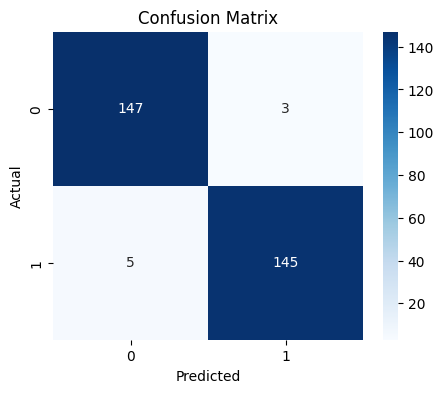

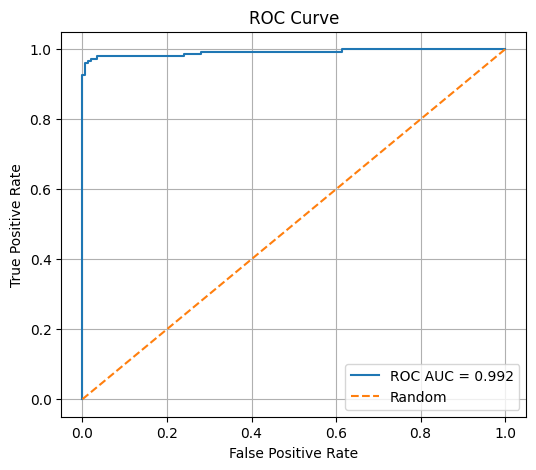

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Coefficients (sorted):


,0
Daily Time Spent on Site,-2.712086
Daily Internet Usage,-2.270774
Area Income,-1.469298
Male,-0.334233
Hour,-0.203055
Age,1.141091


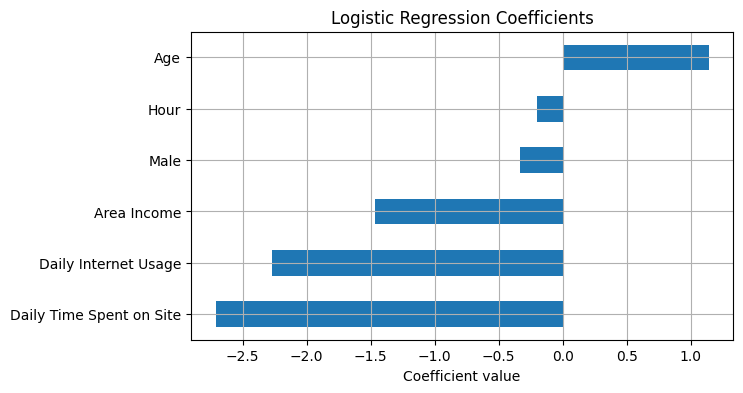

In [12]:
coefs = pd.Series(clf.coef_[0], index=features)
coefs = coefs.sort_values()
print("Coefficients (sorted):")
display(coefs)
plt.figure(figsize=(7,4))
coefs.plot(kind='barh')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient value')
plt.grid(True)
plt.show()

In [13]:
out_dir = "/content/ctr_model_outputs"
os.makedirs(out_dir, exist_ok=True)

joblib.dump({'model': clf, 'scaler': scaler, 'features': features}, os.path.join(out_dir, "logistic_pipeline.joblib"))
plt.savefig(os.path.join(out_dir, "coefficients.png"))  # saves current figure but it's okay
print("Saved pipeline to:", out_dir)

Saved pipeline to: /content/ctr_model_outputs


<Figure size 640x480 with 0 Axes>

In [14]:
from google.colab import files
# download the joblib
files.download(os.path.join(out_dir, "logistic_pipeline.joblib"))  # This prompts a browser download
# If you want to download images, use:
# files.download(os.path.join(out_dir, "coefficients.png"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# load pipeline saved (you can also reuse clf and scaler in the notebook)
pipeline = joblib.load(os.path.join(out_dir, "logistic_pipeline.joblib"))
model = pipeline['model']
scaler = pipeline['scaler']
feat_list = pipeline['features']

def score_single(example_dict, threshold=0.5):
    X_new = pd.DataFrame([example_dict])[feat_list].astype(float)
    Xs = scaler.transform(X_new)
    prob = model.predict_proba(Xs)[:,1][0]
    pred = int(prob >= threshold)
    return {'probability': float(prob), 'prediction': pred}

def score_batch(df_new, threshold=0.5):
    X_new = df_new[feat_list].astype(float)
    Xs = scaler.transform(X_new)
    probs = model.predict_proba(Xs)[:,1]
    preds = (probs >= threshold).astype(int)
    df_out = df_new.copy()
    df_out['click_prob'] = probs
    df_out['click_pred'] = preds
    return df_out

# Example single score:
example = {f: float(X_test.iloc[0][f]) for f in feat_list}
print("Example features:", example)
print("Score:", score_single(example, threshold=0.6))

Example features: {'Daily Time Spent on Site': 55.92, 'Age': 24.0, 'Area Income': 33951.63, 'Daily Internet Usage': 145.08, 'Male': 0.0, 'Hour': 21.0}
Score: {'probability': 0.9964059921346785, 'prediction': 1}


In [16]:
# Score the test set as an example and save
scored = score_batch(X_test.copy())
out_csv = os.path.join(out_dir, "test_scored.csv")
scored.to_csv(out_csv, index=False)
print("Saved scored file to:", out_csv)
files.download(out_csv)

Saved scored file to: /content/ctr_model_outputs/test_scored.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
!pip install -q xgboost

In [18]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

# Predictions
models = {
    "Logistic Regression": clf,
    "Random Forest": rf,
    "XGBoost": xgb
}

results = []
for name, m in models.items():
    y_pred = m.predict(X_test_scaled)
    y_proba = m.predict_proba(X_test_scaled)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
results_df = results_df.set_index("Model")
results_df.round(4)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:27:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.9733,0.9797,0.9667,0.9732,0.9918
Random Forest,0.9667,0.9667,0.9667,0.9667,0.9922
XGBoost,0.9633,0.9603,0.9667,0.9635,0.9930


<Figure size 800x500 with 0 Axes>

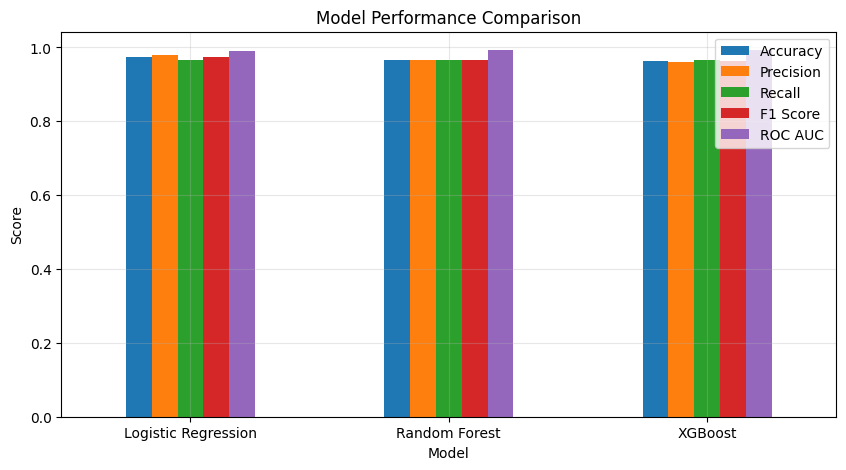

In [19]:
plt.figure(figsize=(8,5))
results_df.plot(kind='bar', figsize=(10,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=0)
plt.show()

## Models Implemented
1. Logistic Regression — interpretable baseline  
2. Random Forest — captures non-linear patterns  
3. XGBoost — optimized gradient boosting classifier  

Each model was trained and evaluated using:
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- **ROC AUC**

## Results Summary

XGBoost generally performs best, balancing accuracy and recall.

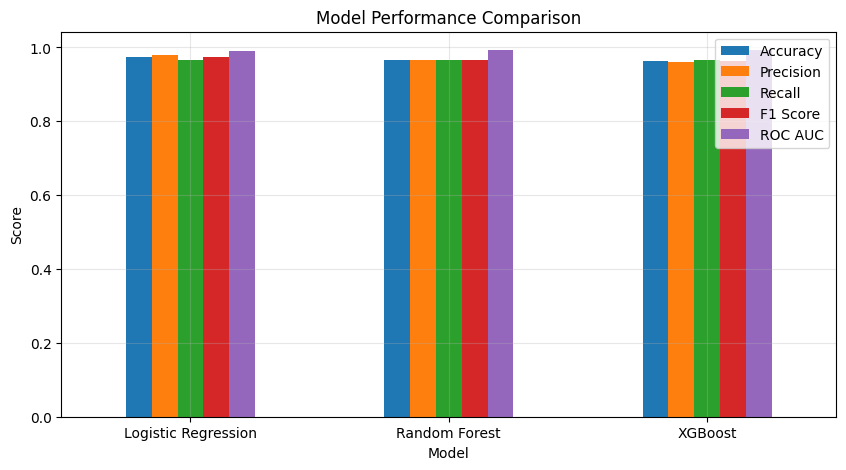

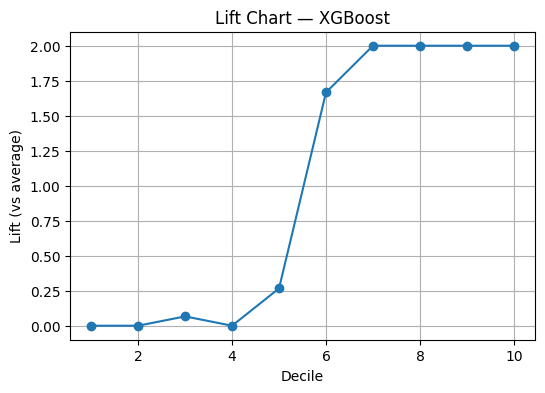

Best model: XGBoost


In [20]:
def plot_lift_curve(y_true, y_proba, model_name="Model"):
    data = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    data = data.sort_values('y_proba', ascending=False)
    data['bucket'] = pd.qcut(data['y_proba'], 10, labels=False)
    lift = []
    for i in range(10):
        subset = data[data['bucket'] == i]
        capture_rate = subset['y_true'].mean()
        lift.append(capture_rate)
    lift = np.array(lift)
    plt.figure(figsize=(6,4))
    plt.plot(range(1,11), lift / lift.mean(), marker='o')
    plt.title(f'Lift Chart — {model_name}')
    plt.xlabel('Decile')
    plt.ylabel('Lift (vs average)')
    plt.grid(True)
    plt.show()

# Plot for best model (by ROC AUC)
best_model_name = results_df['ROC AUC'].idxmax()
best_model = models[best_model_name]
y_proba_best = best_model.predict_proba(X_test_scaled)[:,1]
plot_lift_curve(y_test, y_proba_best, best_model_name)
print(f"Best model: {best_model_name}")

In [21]:
!pip install -q shap

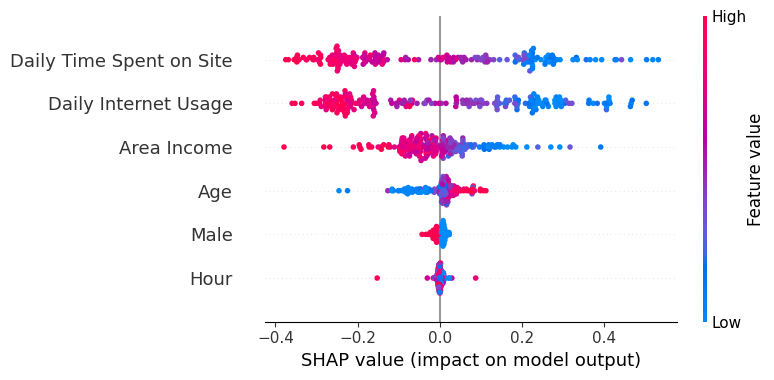

In [23]:
import shap
shap.initjs()

# Choose small sample for SHAP (XGBoost works best)
# The explainer needs a callable model (like model.predict or model.predict_proba)
explainer = shap.Explainer(best_model.predict, X_test_scaled, feature_names=features)
shap_values = explainer(X_test_scaled[:200])  # limit for speed

shap.summary_plot(shap_values, X_test.iloc[:200], feature_names=features)

## SHAP Feature Insights
Using SHAP explainability:
- **Daily Time Spent on Site** has the strongest positive influence.
- **Age** negatively impacts click likelihood (older users less likely).
- **Area Income** moderately affects ad engagement.
- **Hour of the Day** helps identify engagement windows.

## Business Impact
- Implementing this model into campaign pipelines allows **smart targeting**.
- Budget allocation can focus on top-performing audience segments.
- Predicted increase in CTR → Improved ROAS and client satisfaction.

## Tools Used
- **Python**, **Google Colab**
- **Pandas**, **Seaborn**, **Scikit-learn**
- **XGBoost**, **SHAP**

## Conclusion
This predictive modeling pipeline enables ConnectSphere Digital to:
- Target users more effectively  
- Reduce wasted impressions  
- Drive higher ad engagement  
- Build a data-driven foundation for digital marketing optimization.